<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import requests
import re
import os
import tensorflow as tf
import heapq
import numpy as np

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dropout, TimeDistributed, Dense, GRU, SimpleRNN, CategoryEncoding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

## Entrenamiento

### Datos
Se utiliza como dataset para entrenar los modelos el libro de Don Quijote descargado desde la web de gutenberg.

In [ ]:
import requests
from bs4 import BeautifulSoup

def download_gutenberg_txt(book_id):
    url = f"https://www.gutenberg.org/ebooks/{book_id}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    link_tag = soup.find("a", string="Plain Text UTF-8")
    if not link_tag:
        raise Exception("Plain Text link not found.")

    txt_link = link_tag["href"]

    if txt_link.startswith("/"):
        txt_url = f"https://www.gutenberg.org{txt_link}"
    else:
        txt_url = txt_link

    txt_response = requests.get(txt_url)
    txt_content = txt_response.text
    return txt_content

def clean_gutenberg_text(raw_text):
    start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"
    end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"

    start_index = raw_text.find(start_marker)
    end_index = raw_text.find(end_marker)

    if start_index == -1 or end_index == -1:
        raise ValueError("Start or end marker not found in text.")

    content = raw_text[start_index + len(start_marker):end_index]

    return content.strip()

book_text = download_gutenberg_txt(2000)
cleaned_text = clean_gutenberg_text(book_text)
cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip().lower()

In [ ]:
print(cleaned_text[:1000])
print('...')
print(cleaned_text[-1000:])

el ingenioso hidalgo don quijote de la mancha por miguel de cervantes saavedra el ingenioso hidalgo don quijote de la mancha tasa testimonio de las erratas el rey al duque de béjar prólogo al libro de don quijote de la mancha que trata de la condición y ejercicio del famoso hidalgo don quijote de la mancha que trata de la primera salida que de su tierra hizo el ingenioso don quijote donde se cuenta la graciosa manera que tuvo don quijote en armarse caballero de lo que le sucedió a nuestro caballero cuando salió de la venta donde se prosigue la narración de la desgracia de nuestro caballero del donoso y grande escrutinio que el cura y el barbero hicieron en la librería de nuestro ingenioso hidalgo de la segunda salida de nuestro buen caballero don quijote de la mancha del buen suceso que el valeroso don quijote tuvo en la espantable y jamás imaginada aventura de los molinos de viento, con otros sucesos dignos de felice recordación donde se concluye y da fin a la estupenda batalla que el

###  Tokenización del texto

In [ ]:
chars_vocab = set(cleaned_text)
vocab_size = len(chars_vocab)
print(vocab_size)

char2idx = {k: v for v,k in enumerate(chars_vocab)}
print(char2idx)
idx2char = {v: k for k,v in char2idx.items()}
print(idx2char)

tokenized_text = [char2idx[ch] for ch in cleaned_text]

61
{'j': 0, '«': 1, 'p': 2, 'g': 3, 'v': 4, 'q': 5, 'h': 6, '-': 7, 'í': 8, ' ': 9, 'ù': 10, 'd': 11, '2': 12, 'm': 13, 'w': 14, '0': 15, '¡': 16, '¿': 17, ';': 18, '»': 19, 'e': 20, 'i': 21, 'b': 22, 'ï': 23, 'n': 24, 'u': 25, '!': 26, 'é': 27, 'y': 28, 'ü': 29, 'ñ': 30, '.': 31, '4': 32, ':': 33, 's': 34, 'f': 35, 't': 36, '(': 37, '"': 38, '3': 39, 'ó': 40, ']': 41, 'r': 42, ')': 43, '5': 44, '6': 45, 'á': 46, '?': 47, 'l': 48, 'à': 49, 'ú': 50, 'c': 51, ',': 52, 'x': 53, '—': 54, "'": 55, 'z': 56, '7': 57, 'a': 58, 'o': 59, '1': 60}
{0: 'j', 1: '«', 2: 'p', 3: 'g', 4: 'v', 5: 'q', 6: 'h', 7: '-', 8: 'í', 9: ' ', 10: 'ù', 11: 'd', 12: '2', 13: 'm', 14: 'w', 15: '0', 16: '¡', 17: '¿', 18: ';', 19: '»', 20: 'e', 21: 'i', 22: 'b', 23: 'ï', 24: 'n', 25: 'u', 26: '!', 27: 'é', 28: 'y', 29: 'ü', 30: 'ñ', 31: '.', 32: '4', 33: ':', 34: 's', 35: 'f', 36: 't', 37: '(', 38: '"', 39: '3', 40: 'ó', 41: ']', 42: 'r', 43: ')', 44: '5', 45: '6', 46: 'á', 47: '?', 48: 'l', 49: 'à', 50: 'ú', 51: 'c'

In [ ]:
print(tokenized_text[:100])

[20, 48, 9, 21, 24, 3, 20, 24, 21, 59, 34, 59, 9, 6, 21, 11, 58, 48, 3, 59, 9, 11, 59, 24, 9, 5, 25, 21, 0, 59, 36, 20, 9, 11, 20, 9, 48, 58, 9, 13, 58, 24, 51, 6, 58, 9, 2, 59, 42, 9, 13, 21, 3, 25, 20, 48, 9, 11, 20, 9, 51, 20, 42, 4, 58, 24, 36, 20, 34, 9, 34, 58, 58, 4, 20, 11, 42, 58, 9, 20, 48, 9, 21, 24, 3, 20, 24, 21, 59, 34, 59, 9, 6, 21, 11, 58, 48, 3, 59, 9]


### Separación set de entrenamiento y validación

In [ ]:
batch_size = 64
buffer_size = 10000
val_split = 0.1
context_size = 128

sequences = tf.data.Dataset.from_tensor_slices(tokenized_text)

sequences = sequences.window(context_size + 1, shift=1, drop_remainder=True)
sequences = sequences.flat_map(lambda window: window.batch(context_size + 1))

def split_input_target(seq):
    input_seq = seq[:-1]
    target_seq = seq[1:]
    return input_seq, target_seq

sequences = sequences.map(split_input_target)

text_length = len(tokenized_text)
total_sequences = text_length - context_size
print("Total de secuencias:", total_sequences)

val_size = int(total_sequences * val_split)

train_dataset = (
    sequences
    .skip(val_size)
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    sequences
    .take(val_size)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

Total de secuencias: 2104835


In [ ]:
def perplexity(y_true, y_pred):
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(K.mean(cross_entropy))

### Definiendo los modelos

Se proponen 3 modelos a comparar. Un SimpleRNN, un GRU y un LSTM.

In [ ]:
simple_rnn_model = Sequential([
  TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)),
  SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ),
  Dense(vocab_size, activation='softmax')
])

simple_rnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=[perplexity]
)
simple_rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 61)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 61)       │        12,261 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,661 (252.58 KB)

 Trainable params: 64,661 (252.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
embedding_dim = 128

In [ ]:
gru_model = Sequential([
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)),
    GRU(embedding_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    GRU(embedding_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    TimeDistributed(Dense(vocab_size, activation='softmax'))
])

gru_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=[perplexity]
)

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 61)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 128)      │        73,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 61)       │         7,869 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,285 (704.24 KB)

 Trainable params: 180,285 (704.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model = Sequential([
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)),
    LSTM(embedding_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(embedding_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    TimeDistributed(Dense(vocab_size, activation='softmax'))
])

lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=[perplexity]
)

lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, None, 61)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │        97,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, None, 61)       │         7,869 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,733 (924.74 KB)

 Trainable params: 236,733 (924.74 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

Se incluyen dos callbacks


*   ModelCheckpoint: para guardar los mejores modelos en función de la metrica de perplexity de validación.
*   EarlyStopping: para evitar sobreajuste, si no se ve mejora (disminución) en la metrica de val_perplexity, el modelo deja de entrenar y se restauran los pesos de la mejor epoca.



In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def fit_model(model, name):

  checkpoint = ModelCheckpoint(
    filepath=name,
    monitor='val_perplexity',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
  )

  early_stop = EarlyStopping(
      monitor='val_perplexity',
      patience=3,
      restore_best_weights=True,
      mode='min'
  )

  steps_per_epoch = 2000

  history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    callbacks=[checkpoint, early_stop]
  )

  plt.plot(history.history['perplexity'], label='Perplejidad - Entrenamiento')
  plt.plot(history.history['val_perplexity'], label='Perplejidad - Validación')
  plt.xlabel('Época')
  plt.ylabel('Perplejidad')
  plt.legend()
  plt.grid(True)
  plt.title('Perplejidad')
  plt.show()

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 198s 86ms/step - loss: 2.1928 - perplexity: 9.8846 - val_loss: 1.8018 - val_perplexity: 6.1679
Epoch 2/20
   3/2000 ━━━━━━━━━━━━━━━━━━━━ 1:38 49ms/step - loss: 1.7527 - perplexity: 5.7716

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 171s 85ms/step - loss: 1.7098 - perplexity: 5.5322 - val_loss: 1.7117 - val_perplexity: 5.6587
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 171s 85ms/step - loss: 1.6233 - perplexity: 5.0730 - val_loss: 1.6614 - val_perplexity: 5.3926
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 170s 85ms/step - loss: 1.5690 - perplexity: 4.8044 - val_loss: 1.6799 - val_perplexity: 5.5011
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 170s 85ms/step - loss: 1.5482 - perplexity: 4.7069 - val_loss: 1.6797 - val_perplexity: 5.4984
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 170s 85ms/step - loss: 1.5301 - perplexity: 4.6219 - val_loss: 1.6311 - val_perplexity: 5.2314
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 172s 86ms/step - loss: 1.5705 - perplexity: 4.8129 - val_loss: 1.6296 - val_perplexity: 5.2200
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 171s 85ms/step - loss: 1.5439 - perplexity: 4.6857 - val_loss: 1.6150 - val_perplexity: 5.1498
Epoch 9/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 170s 85ms/

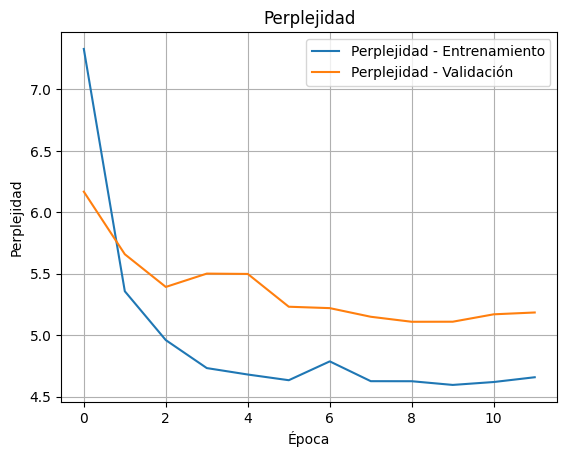

In [ ]:
fit_model(simple_rnn_model, 'simple_rnn_model.keras')

Conclusiones entrenamiento modelo simpleRNN

*   En la época 1 la perplexity de entrenamiento cae de ~9 a ~5.5 en la época 2, y la de validación de ~6.2 a ~5.6 Esto indica que el modelo está capturando patrones básicos del lenguaje muy pronto.
*   La mejor perplexity de validación (~5.11) se alcanza en la época 9. A partir de ahí, la curva de validación se estabiliza e incluso comienza a subir ligeramente, señal de que ya no está adquiriendo conocimiento nuevo.
*   La perplexity de entrenamiento converge en torno a 4.6, mientras que la de validación se mantiene en 5.1-5.2. Esta diferencia muestra un sobreajuste ligero: el modelo memoriza un poco más el conjunto de entrenamiento que lo que generaliza al de validación.
*   El entrenamiento se cortó al no presentar mejoras significativas por 3 epochs por el callback de EarlyStopping

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 390s 182ms/step - loss: 2.3261 - perplexity: 11.4660 - val_loss: 1.7443 - val_perplexity: 5.8237
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 362s 181ms/step - loss: 1.6757 - perplexity: 5.3489 - val_loss: 1.6290 - val_perplexity: 5.2190
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 363s 182ms/step - loss: 1.5312 - perplexity: 4.6273 - val_loss: 1.5710 - val_perplexity: 4.9409
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 363s 182ms/step - loss: 1.4558 - perplexity: 4.2906 - val_loss: 1.5832 - val_perplexity: 5.0202
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 363s 182ms/step - loss: 1.4238 - perplexity: 4.1561 - val_loss: 1.5755 - val_perplexity: 4.9791
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 364s 182ms/step - loss: 1.3911 - perplexity: 4.0220 - val_loss: 1.5201 - val_perplexity: 4.6939
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 364s 182ms/step - loss: 1.4325 - perplexity: 4.1921 - val_loss: 1.4994 - val_perplexity: 4.5940
Epoch 8/20
2000/2000 ━━━━━━━━━━━━

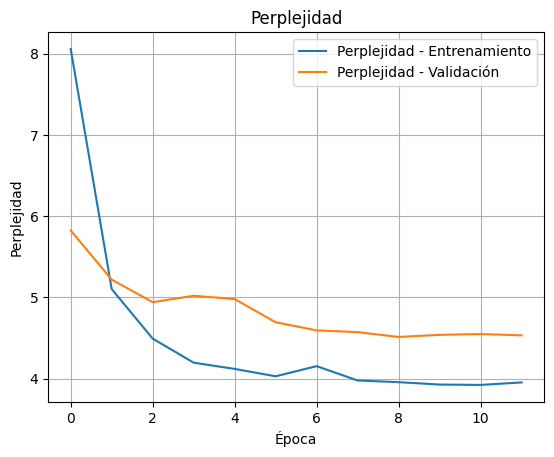

In [ ]:
fit_model(gru_model, 'gru_model.keras')

Conclusiones entrenamiento modelo GRU

*   Las curvas de aprendizaje son bastante similares entre el modelo SimpleRNN y GRU. Los valores de perplexity, sin embargo, son levemente menores para el GRU.
*   En la época 1 la perplexity de entrenamiento pasa de ~11.5 a ~5.3 en la época 2, y la de validación de ~5.8 a ~5.2. Lo que muestra que el modelo GRU capta muy pronto las estructuras básicas del lenguaje
*   La perplexity de validación alcanza su mínimo (~4.5) en la época 9. A partir de ahí comienza a estabilizarse.
*   La perplexity de entrenamiento converge alrededor de 3.8-4, mientras que la de validación se sitúa en 4.5-4.6. Esta diferencia muestra un sobreajuste ligero: el modelo memoriza algo más el conjunto de entrenamiento que lo que alcanza a generalizar.
*   El entrenamiento se cortó al no presentar mejoras significativas por 3 epochs por el callback de EarlyStopping

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 418s 194ms/step - loss: 2.6416 - perplexity: 15.0153 - val_loss: 2.0096 - val_perplexity: 7.5254
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 390s 195ms/step - loss: 2.0291 - perplexity: 7.6136 - val_loss: 1.8758 - val_perplexity: 6.6045
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 389s 195ms/step - loss: 1.8955 - perplexity: 6.6590 - val_loss: 1.8006 - val_perplexity: 6.1437
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 393s 196ms/step - loss: 1.7995 - perplexity: 6.0506 - val_loss: 1.7706 - val_perplexity: 5.9693
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 400s 200ms/step - loss: 1.7461 - perplexity: 5.7348 - val_loss: 1.7411 - val_perplexity: 5.8034
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 388s 194ms/step - loss: 1.6956 - perplexity: 5.4523 - val_loss: 1.6749 - val_perplexity: 5.4318
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 390s 195ms/step - loss: 1.7091 - perplexity: 5.5274 - val_loss: 1.6497 - val_perplexity: 5.3008
Epoch 8/20
2000/2000 ━━━━━━━━━━━━

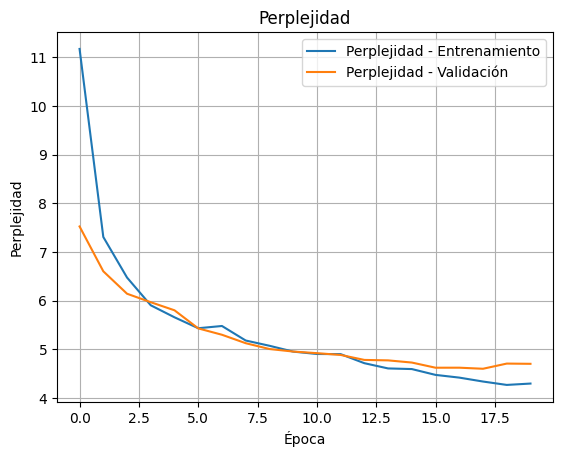

In [ ]:
fit_model(lstm_model, 'lstm_model.keras')

Conclusiones entrenamiento modelo LSTM

*   En la época 1 la perplexity de entrenamiento cae de ~15 a ~7.6, y la de validación de ~7.5 a ~6.6. En pocas épocas ya estamos por debajo de perplexity de 5, lo que indica que el LSTM capta muy pronto las dependencias básicas del texto.
*   La perplexity de validación alcanza su mínimo (~4.60) en la época 18.
*   La perplexity de entrenamiento sigue bajando hasta ~4.3 en la época 20, con oscilaciones menores tras la época 10. Esto muestra que el modelo aún “aprende” del conjunto de train incluso después de que la validación haya comenzado a estabilizarse. Esto indica un ligero sobreajuste, pero menor que el de los casos anteriores.


## Comparación modelos

In [ ]:
custom_objs = {
    'perplexity': perplexity,
    'CategoryEncoding': CategoryEncoding
}
simple_rnn_model = load_model('simple_rnn_model.keras', custom_objects=custom_objs)
gru_model = load_model('gru_model.keras', custom_objects=custom_objs)
lstm_model = load_model('lstm_model.keras', custom_objects=custom_objs)

models = {
    'SimpleRNN': simple_rnn_model,
    'GRU': gru_model,
    'LSTM': lstm_model
}


### Predicción del próximo caracter

In [ ]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gradio as gr

def predict_next_char(text):
    results = {}
    for model_name, model in models.items():
        encoded = [char2idx[ch] for ch in text.lower() ]
        encoded = pad_sequences([encoded], maxlen=context_size, padding='pre')

        y_hat = np.argmax(model.predict(encoded)[0,-1,:])

        out_word = idx2char[y_hat]

        results[model_name] = text + out_word

    return results['SimpleRNN'], results['GRU'], results['LSTM']

iface = gr.Interface(
    fn=predict_next_char,
    inputs=gr.Textbox(label="Input Text"),
    outputs=[
        gr.Textbox(label="SimpleRNN Prediction"),
        gr.Textbox(label="GRU Prediction"),
        gr.Textbox(label="LSTM Prediction")
    ],
    title="Next Character Prediction",
    description="Predicts the next character using different RNN models."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://342e740286de82841f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Generación de secuencias

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    output_text = seed_text
    for _ in range(n_words):
        encoded = [char2idx[ch] for ch in output_text.lower() ]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
        out_word = ''

        out_word = idx2char[y_hat]

        output_text += out_word
    return output_text

In [ ]:
input_texts=['el duque', 'el castillo', 'don quijote', 'la espada']

In [ ]:
for input_text in input_texts:
  print(generate_seq(simple_rnn_model, input_text, max_length=context_size, n_words=30))

el duque se dejando en la mano de la m
el castillo de la mano de la mano de la m
don quijote de la mano de la mano de la m
la espada de la mano de la mano de la m


El modelo SimpleRNN muestra mucha repetición, se queda atascado en la frase "en la mano de la mano". Esto puede ser por tener muy poca memoria de largo plazo.

In [ ]:
for input_text in input_texts:
  print(generate_seq(gru_model, input_text, max_length=context_size, n_words=30))

el duque de la mano de la mano de la m
el castillo de la mano de la mano de la m
don quijote y a la mano de la mano de la 
la espada, y a la mano de la mano de la


El modelo GRU cuenta con los mismos problemas que SimpleRNN, repetición de la misma frase.

In [ ]:
for input_text in input_texts:
  print(generate_seq(lstm_model, input_text, max_length=context_size, n_words=30))

el duque yo se le dijo don quijote—, y
el castillo de la venta de la venta de la
don quijote—, y así es está en el cura—, 
la espada de la venta de la venta de la


El resultado del modelo LSTM es mixto. Dos de las 4 salidas tienen un formato bastante repetitivo, mientras que las otras dos son más coherentes e incluyen signos de puntuación.

###  Beam search y muestreo aleatorio

In [ ]:
def encode(text,max_length=context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams]
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp))
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    encoded = encode(input)
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    vocab_size = y_hat.shape[0]

    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        input_update = np.array([hist[i+1:]]).copy()

        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
for input_text in input_texts:
  salidas = beam_search(simple_rnn_model,num_beams=10,num_words=30,input=input_text)
  print(decode(salidas[0]))

el duque le dijo don quijote—, que no 
el castillo, dijo don quijote—, que no se
don quijote, que no le dijo don quijote, 


Se observan algunas mejoras frente a los resultados de greedy search. El resultado no termina siendo del todo coherente y repite la frase "dijo don quijote-, que no se"

In [ ]:
for input_text in input_texts:
  salidas = beam_search(gru_model,num_beams=5,num_words=30,input=input_text)
  print(decode(salidas[0]))

el duque de la cueva de la cueva de la
el castillo que le dijo don quijote, que 
don quijote, que le dijo don quijote, que


Al igual que ocurre con SimpleRNN, los resultados son levemente mejores a los previos, pero sigue ocurriendo una repetición de frases.

In [ ]:
for input_text in input_texts:
  salidas = beam_search(lstm_model,num_beams=5,num_words=30,input=input_text)
  print(decode(salidas[0]))

el duque don quijote—, que no le había
el castillo, que no le había de la ventur
don quijote—, porque no le había de aquel


Los resultados de LSTM son similares a los obtenidos con GRU. Tienen mayor coherencia que los generados con greedy search, pero siguen teniendo bastante repetición de frases.

In [ ]:
salidas = beam_search(lstm_model,num_beams=10,num_words=100,input='la espada', temp=1.5)
print(decode(salidas[0]))

la espada, porque no le había de la caballería de la caballería de la caballería de la ventura, que no había 


In [ ]:
salidas = beam_search(lstm_model,num_beams=5,num_words=100,input='la espada', temp=0.5)
print(decode(salidas[0]))

la espada, que no le había de caballero de la ventura, que no le había de caballero de la ventura, que no se 


Extendiendo la cantidad de caracteres y probando combinaciones de parametros de temepratura y num_beans, los resultados siguen teniendo repeticiones. Se podría penalizar las repeticiones para obtener resultados más variados. La puntuación, a pesar de la reiteración, parece ser correcta.

En conjunto, tanto en greedy search como con Beam Search los Simple RNN sufren de bucles muy repetitivos por su escasa memoria, las GRU añaden algo de variedad y retienen mejor contextos intermedios, y las LSTM mayor fluidez y coherencia al mantener dependencias a largo plazo.
Utilizando Greedy Search se utiliza siempre el carácter de máxima probabilidad, lo que hace quedar atrapado en bucles de repetición muy cortos.
Beam Search mejora la gramática local pero sigue contando con patrones frecuentes y repeticiones si estos no se penalizan.